# Machine Learning for Multibody System Dynamics

## **Session 2-2:** Automated Machine Learning with Duffing Oscillator 

Grzegorz Orzechowski & Peter Manzl

> Grid-search AutoML built on top of Duffing-oscillator dynamics.

In [1]:
# 1) Imports and Setup
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import time
from itertools import product
import random

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Duffing Oscillator [Same as earlier]

In this file, a deep neural network is trained on the dynamics of a [Duffing oscillator](https://en.wikipedia.org/wiki/Duffing_equation). The equations of motion (EOM) are:

$$m \,\ddot{x} + d \,\dot{x} + k \,x + \alpha \,k \,x^3 = F(t).$$

In the used dataset, parameters are fixed as:
-  $m = 1$,
-  $k = 1600$,
-  $d = 8$,
-  $\alpha = 1$.

Randomized forces $F_i$ are applied in the range $\bigl[-2000,\,2000\bigr]$. For learning, inputs are normalized as $\hat{f}_i = \tfrac{1}{2000}F_i$.

**Input vector**:

$\bigl[x_0,\;\dot{x}_0,\;\hat{f}_0,\;\dots,\;\hat{f}_{n-1}\bigr]^T.$

**Output vector**:
$\bigl[x_1,\;x_2,\;\dots,\;x_n\bigr]^T, \quad x_i = x\bigl(t = i\,h\bigr),\quad h = \tfrac{0.5}{64}.$

- **Dataset 1**: Randomized forces for each sample.
- **Dataset 2**: Randomized harmonics with $\omega \in [0,\,4\pi]$ (uniform), amplitude also in $[-2000,\,2000]$.

Below, we generate both datasets, train a DNN surrogate, and compare predictions to true trajectories.

### Problem Setup

- Time step: $h = \tfrac{0.5}{64}$.
- Number of steps per trajectory: $n = 64$.
- Total integration time: $T = n \times h = 0.5\,$s.
- Time vector: $t_i = i\,h$ for $i=0,\dots,n$.

Define constants and the Duffing ODE (second-order rewritten as first-order).

In [2]:
# 2) Constants for the Duffing Oscillator and time grid
m, k, damp, alpha = 1.0, 1600.0, 8.0, 1.0
n_steps = 64
h       = 0.5 / n_steps
T       = h * n_steps
t_steps = np.linspace(0, T, n_steps + 1)


In [3]:
# 3) Duffing ODE RHS (first‐order form)
def duffing_rhs(t, u, forces):
    # u = [x, v], piecewise‐constant forcing
    idx = min(int(t / h), len(forces)-1)
    F_t = forces[idx]
    x, v = u
    dx = v
    dv = F_t - damp * v - k * x - alpha * k * x**3
    return [dx, dv]

### Generate Dataset 1: Randomized Forces

For each sample:
1. Random initial state $\bigl(x_0,\dot{x}_0\bigr)\in[-1,\,1]$.
2. Random force sequence $F_i \sim \mathcal{U}(-2000,\,2000)$ for $i=0,\dots,\,n-1$.
3. Normalize $\hat{f}_i = F_i / 2000$.
4. Integrate the ODE for $t\in[0,\,T]$ with forcing $F(t)$ piecewise constant on $[i\,h,\,(i+1)\,h)$.
5. Record positions $x_1,\dots,x_n$ at $t=h,\dots,T$.

In [4]:
# 4) Dataset 1 generation
seed = 123
rng = np.random.default_rng(seed)
N1 = 4000

inputs1  = np.zeros((N1, 2 + n_steps), dtype=np.float32)
targets1 = np.zeros((N1, n_steps),    dtype=np.float32)

for i in range(N1):
    x0 = rng.random()*2 - 1
    v0 = rng.random()*2 - 1
    F_seq = rng.random(n_steps)*4000 - 2000
    fhat = F_seq / 2000.0

    # store inputs
    inputs1[i, 0] = x0
    inputs1[i, 1] = v0
    inputs1[i, 2:] = fhat

    # integrate
    sol = solve_ivp(lambda t,y: duffing_rhs(t,y,F_seq),
                    (0, T), [x0, v0],
                    t_eval=t_steps, method='RK45')
    # record positions at t_steps[1:]
    targets1[i] = sol.y[0, 1:]
    
print(f"Dataset1: inputs {inputs1.shape}, targets {targets1.shape}")

Dataset1: inputs (4000, 66), targets (4000, 64)


### Generate Dataset 2: Randomized Harmonics

For each sample:
1. Random initial state $(x_0,\dot{x}_0)$.
2. Random amplitude $A \sim \mathcal{U}(-2000,\,2000)$, random $\omega \sim \mathcal{U}(0,\,4\pi)$.
3. Define force sequence $F_i = A \sin(\omega \, t_i)$, then normalize: $\hat{f}_i = F_i/2000$.
4. Integrate Duffing ODE with this forcing and record $x_1,\dots,x_n$.

In [5]:
# 5) Dataset 2 generation
seed = 456
rng = np.random.default_rng(seed)
N2 = 4000

inputs2  = np.zeros((N2, 2 + n_steps), dtype=np.float32)
targets2 = np.zeros((N2, n_steps),    dtype=np.float32)

for i in range(N2):
    x0 = rng.random()*2 - 1
    v0 = rng.random()*2 - 1
    A  = rng.random()*4000 - 2000
    ω  = rng.random()*(4*np.pi)

    F_seq = A * np.sin(ω * t_steps[:-1])
    fhat = F_seq / 2000.0

    inputs2[i, 0] = x0
    inputs2[i, 1] = v0
    inputs2[i, 2:] = fhat

    sol = solve_ivp(lambda t,y: duffing_rhs(t,y,F_seq),
                    (0, T), [x0, v0],
                    t_eval=t_steps, method='RK45')
    targets2[i] = sol.y[0,1:]

print(f"Dataset2: inputs {inputs2.shape}, targets {targets2.shape}")

Dataset2: inputs (4000, 66), targets (4000, 64)


## Combine, Shuffle, and Split

Stack both datasets, then 80% train / 20% test.

In [6]:
# 6) Combine and split
X_all = np.vstack([inputs1, inputs2])
Y_all = np.vstack([targets1, targets2])
N_all = X_all.shape[0]

perm = np.arange(N_all)
rng.shuffle(perm)
split = int(0.8 * N_all)
train_idx, test_idx = perm[:split], perm[split:]

X_train = torch.from_numpy(X_all[train_idx]).float().to(device)
Y_train = torch.from_numpy(Y_all[train_idx]).float().to(device)
X_test  = torch.from_numpy(X_all[test_idx]).float().to(device)
Y_test  = torch.from_numpy(Y_all[test_idx]).float().to(device)

print(f"Train samples: {len(train_idx)}, Test samples: {len(test_idx)}")

Train samples: 6400, Test samples: 1600


## Build MLP by Hyperparameters

We’ll dynamically construct a `torch.nn.Sequential` with:
- input dim = $2 + n_{\rm steps}$,
- `layers_count` hidden layers each of size `hidden_dim`,
- dropout,
- final linear to $n_{\rm steps}$.

In [7]:
# 7) Model‐builder factory
def make_mlp(input_dim, hidden_dim, layers_count, dropout_rate, activation):
    layers = []
    in_dim = input_dim
    for _ in range(layers_count):
        layers.append(nn.Linear(in_dim, hidden_dim))
        layers.append(activation())
        if dropout_rate > 0:
            layers.append(nn.Dropout(dropout_rate))
        in_dim = hidden_dim
    layers.append(nn.Linear(in_dim, n_steps))
    return nn.Sequential(*layers).to(device)

## Training Loop with Early Stopping

Returns `(train_hist, val_hist)` lists.

In [8]:
# 8) Training helper
def train_loop(model, train_loader, val_loader, optimizer, criterion, n_epochs=100, patience=20):
    best_val = float('inf')
    no_imp   = 0
    best_wts = None

    train_hist, val_hist = [], []

    for epoch in range(1, n_epochs+1):
        # train
        model.train()
        running = 0.0
        for xb,yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
            running += loss.item()
        train_hist.append(running / len(train_loader))

        # val
        model.eval()
        vrun = 0.0
        with torch.no_grad():
            for xb,yb in val_loader:
                vrun += criterion(model(xb), yb).item()
        vloss = vrun / len(val_loader)
        val_hist.append(vloss)

        if vloss < best_val:
            best_val = vloss
            best_wts = model.state_dict()
            no_imp = 0
        else:
            no_imp += 1
            if no_imp >= patience:
                print(f"Early stop @ epoch {epoch}")
                break

    model.load_state_dict(best_wts)
    return train_hist, val_hist

## Hyperparameter Grid Search (AutoML)

We sweep over  
- `hidden_dim` in $\{128,256\}$,  
- `lr` in $\{1e-3,5e-3\}$,  
- `batch_size` in $\{64,128\}$,  
- `dropout_rate` in $\{0.01,0.001\}$,  
- `layers_count` in $\{2,3\}$,  
- `activation` in $\{\mathrm{SiLU},\mathrm{SELU}\}$,  

training each for `epochs_grid=60` and recording final validation loss.

In [9]:
# 9) Grid search
hidden_dims      = [128, 256]
lrs              = [1e-3, 5e-3]
batch_sizes      = [64, 128]
dropouts         = [0.01, 0.001]
layers_counts    = [2, 3]
activations      = [nn.SiLU, nn.SELU]

epochs_grid = 60
weight_decay = 1e-3
criterion = nn.MSELoss()

results = []

t0 = time.time()
for hd, lr, bs, dr, lc, act in product(hidden_dims, lrs, batch_sizes, dropouts, layers_counts, activations):
    # data loaders
    tr_ld = DataLoader(TensorDataset(X_train, Y_train), batch_size=bs, shuffle=True)
    val_ld = DataLoader(TensorDataset(X_test,  Y_test ), batch_size=bs, shuffle=False)

    # model & optimizer
    torch.manual_seed(0)
    model = make_mlp(2+n_steps, hd, lc, dr, act)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # train
    _, val_hist = train_loop(model, tr_ld, val_ld, optimizer, criterion,
                             n_epochs=epochs_grid, patience=50)

    results.append({
        'hidden_dim': hd,
        'lr': lr,
        'batch_size': bs,
        'dropout': dr,
        'layers': lc,
        'activation': act.__name__,
        'val_loss': val_hist[-1]
    })

print(f"Grid search done in {time.time()-t0:.1f}s; {len(results)} runs")

Grid search done in 356.2s; 64 runs


### Box‐whisker (“candle”) plots

Visualize how validation loss varies with each hyperparameter.

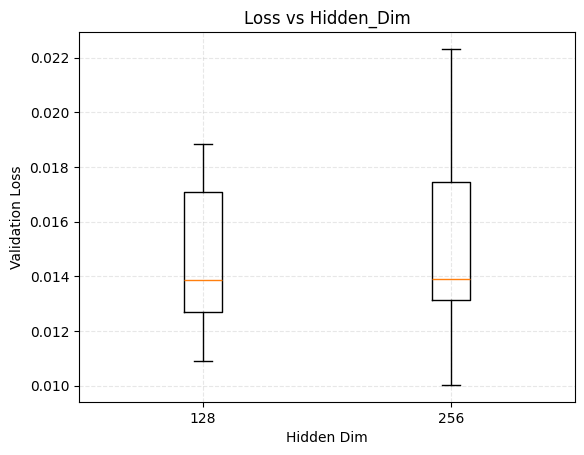

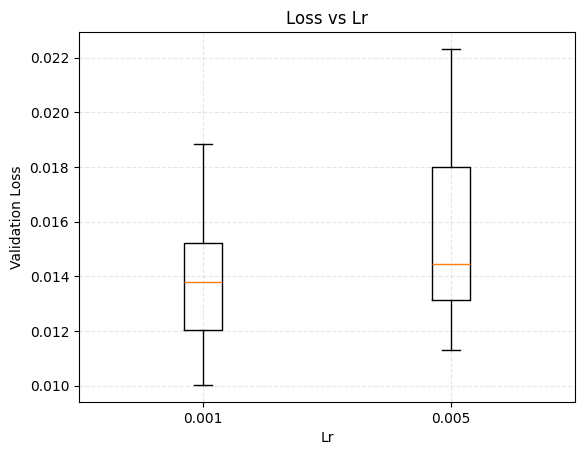

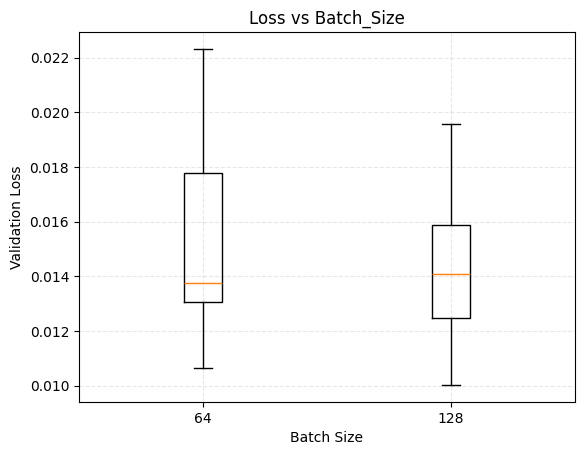

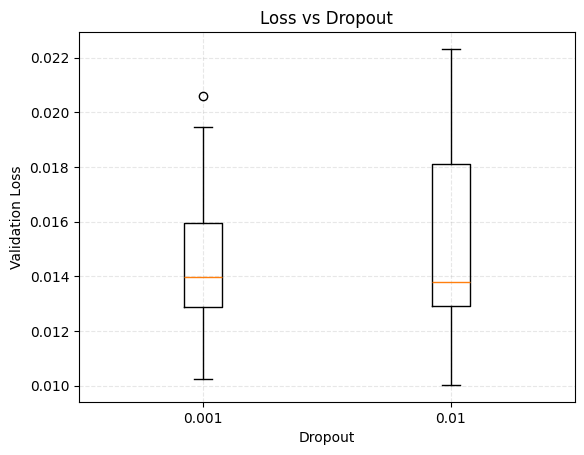

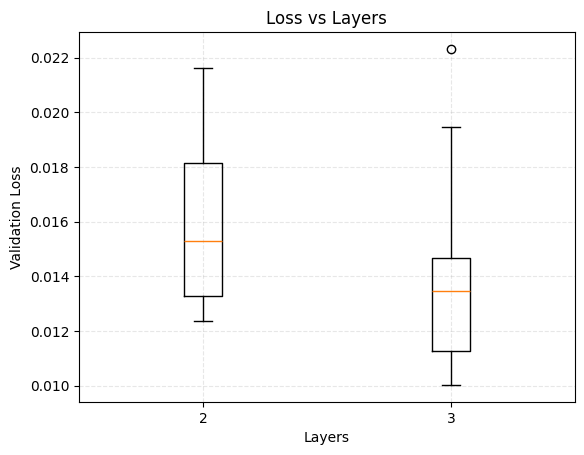

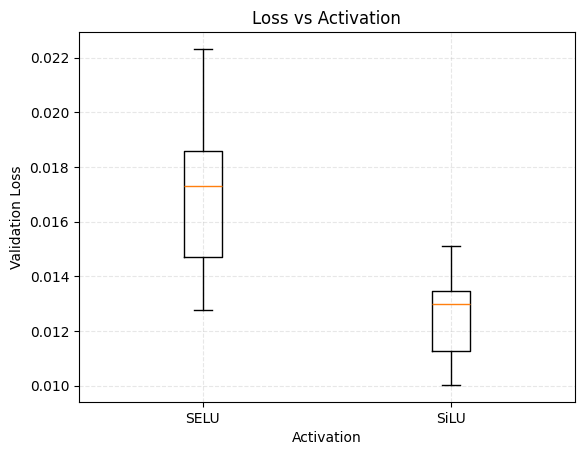

In [10]:
# 10) Candle plots for each hyperparam
import matplotlib.ticker as mtick

def candle_plot(param_name):
    vals = sorted({r[param_name] for r in results})
    grouped = [[r['val_loss'] for r in results if r[param_name]==v] for v in vals]
    plt.figure()
    plt.boxplot(grouped, tick_labels=[str(v) for v in vals])
    plt.xlabel(param_name.replace('_',' ').title())
    plt.ylabel('Validation Loss')
    plt.title(f"Loss vs {param_name.title()}")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()

for pname in ['hidden_dim','lr','batch_size','dropout','layers','activation']:
    candle_plot(pname)

## Select Best Hyperparameters & Retrain Final Model

1. Find the config with lowest `val_loss`.  
2. Retrain on full training set for `nEpoch_final=2000` epochs.

In [11]:
# 11) Pick best config
best = min(results, key=lambda r: r['val_loss'])
print("Best config:", best)

# retrain final model
final_bs  = best['batch_size']
final_tr  = DataLoader(TensorDataset(X_train, Y_train),
                       batch_size=final_bs, shuffle=True)
final_val = DataLoader(TensorDataset(X_test,  Y_test),
                       batch_size=final_bs, shuffle=False)

final_model = make_mlp(2+n_steps,
                       best['hidden_dim'],
                       best['layers'],
                       best['dropout'],
                       getattr(nn, best['activation']))
final_opt = optim.AdamW(final_model.parameters(),
                        lr=best['lr'],
                        weight_decay=weight_decay)

nEpoch_final = 2000
train_hist_f, val_hist_f = train_loop(final_model,
                                      final_tr,
                                      final_val,
                                      final_opt,
                                      criterion,
                                      n_epochs=nEpoch_final,
                                      patience=50)
print(f"Final val loss: {val_hist_f[-1]:.6f}")

Best config: {'hidden_dim': 256, 'lr': 0.001, 'batch_size': 128, 'dropout': 0.01, 'layers': 3, 'activation': 'SiLU', 'val_loss': 0.010021239447479065}
Early stop @ epoch 107
Final val loss: 0.010242


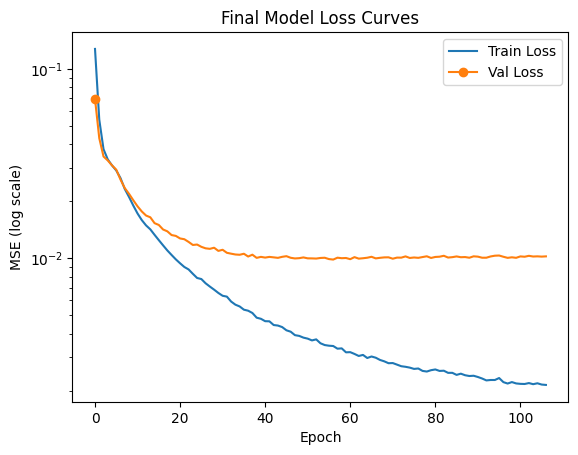

In [12]:
# 12) Plot final loss curves
plt.figure()
plt.semilogy(train_hist_f, label='Train Loss')
plt.semilogy(val_hist_f,   label='Val Loss', marker='o', markevery=200)
plt.xlabel('Epoch')
plt.ylabel('MSE (log scale)')
plt.legend()
plt.title('Final Model Loss Curves')
plt.show()

### Final Prediction vs True Trajectory

Pick one test sample and compare.

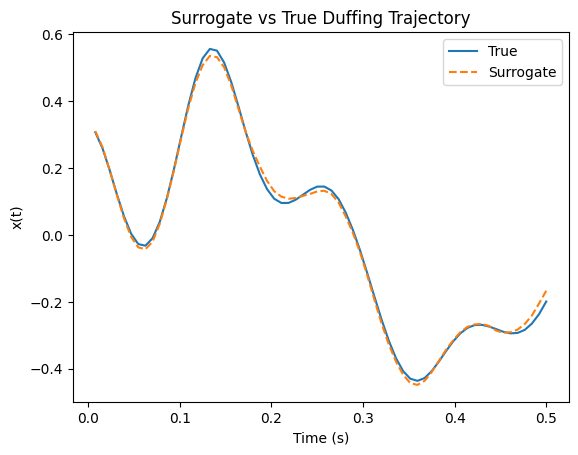

In [13]:
# 13) Compare one example
idx = random.randrange(len(X_test))
x_in = X_test[idx:idx+1]
true = Y_test[idx].cpu().numpy()

with torch.no_grad():
    pred = final_model(x_in).cpu().numpy().ravel()

t_plot = t_steps[1:]

plt.figure()
plt.plot(t_plot, true, label='True')
plt.plot(t_plot, pred, '--', label='Surrogate')
plt.xlabel('Time (s)')
plt.ylabel('x(t)')
plt.title('Surrogate vs True Duffing Trajectory')
plt.legend()
plt.show()